<a id="ID_explore"></a>
| [1.0 Introduction](#ID_int) | [2.0 Literature Review](#ID_lit) | [3.0 Data](#ID_dat) | [4.0 Exploratory Data Analysis](#ID_exp) | [5.0 Methodology](#ID_met) | [6.0 Results](#ID_res) | [7.0 Discussion & Conclusion](#ID_dis) | [Reference](#ID_ref) | [Appendix](#ID_app) |

#### About This Document
This document is part of the coursework for the Data Science for Spatial Systems module (CASA0006) at UCL CASA. You can find the source code and the data associated with this assignment hosted on my GitHub. 
Access it [here](https://github.com/burhanucl2023/Data_Science_UCL).

# Analyzing Spatial Clustering of Public Service Facilities in Andhra Pradesh, India: An Application of K-means, Hierarchical, and DBSCAN Clustering Methods

<div align="right">
  <strong>Word Count: 1996</strong>
</div>

![](https://github.com/burhanucl2023/Data_Science_UCL/raw/main/images/Andhra_Pradesh.JPG)


## 1.0 | Introduction
<a id="ID_int"></a>

This study explores the spatial clustering of the different public service facilities (Health, Transport, Education & Agricultural) for one of the newest split states of India viz. Andhra Pradesh. The erstwhile Andhra Pradesh was split into two states - Telangana & Andhra Pradesh (‘Andhra Pradesh Reorganisation Act, 2014’, 2024). The reorganization led to a redistribution of resources and creation of new administrative blocks. So, our study will look at the distribution & the spatial clustering of facilities thus exploring the regional disparities between blocks effectively. 

So, from this study, we aim to answer these questions:- 
- Q1: How are health, transport, education, and agriculture public services spatially distributed at a block level across the entire state of Andhra Pradesh post its bifurcation?
- Q2: How do different clustering methods (K-means, Hierarchical, DBSCAN) reveal distinct spatial clusters of public service facilities in the state?
- Q3: How does the public service facilities vary within each cluster?

## 2.0 | Literature Review
<a id="ID_lit"></a>

The unequal distribution of public service facilities leads to the disparity in a region and thus further leading to gentrification and alineation with some pockets having the best public service facilities while others having substandard or non-existent. Approximately 70 percent of the population in India lives in rural regions, where there are fewer public services compared to urban areas (Khan, 2015). Further, this creates a disparity between the regions and leading to population migration from poor to better serviced areas. The use of clustering methods like k-means,etc to check the spatial clustering is one of the ways to check the agglomeration of facilities. One of the recent studies  (Khosravi Kazazi et al., 2022), explored the  use of K-means in spatial accessibility to four different types of healthcare services, including hospitals, pharmacies, clinics, and medical laboratories in Iran. Similar, study by (Cesario, Vinci and Zhu, 2020) explored the use of hierarchical clustering for spatial urban circles. Also, (Li Xinyan and Li Deren, 2005) applied DBSCAN to conduct cluster analysis on the distribution of public facilities such as primary and secondary schools and commercial outlets in a city.  In our study, we first plan to identify the distribution of public service facilities (Health, Transport, Education & Agricultural) and then use different clustering methods to observe the clustering patterns at the block level in the newly bifurcated state of Andhra Pradesh. We will employ different clustering techniques such as K-means, hierarchical clustering, and DBSCAN, to reveal the clusters and further, we will examine the characteristics of these clusters for the public service facilities.

## 3.0 | Data
<a id="ID_dat"></a>

### 3.1 Data Source

The data is available as Open Source Data from the Government of India & hosted at [National Open Data GIS](https://geosadak-pmgsy.nic.in/OpenData) as well as a cumulative data set is available [here](https://github.com/datameet/pmgsy-geosadak).

1. **Facility Data** - Represented by `facilities_gdf`- provides details of Public Service Facilities for the state of Andhra Pradesh.
2. **Boundary Data** - Represented by `boundary_gdf`- provides details of Block Boundaries for the state of Andhra Pradesh.

| Data          | Dataframe      | Columns       | Description                                                                                              |
|---------------|----------------|---------------|----------------------------------------------------------------------------------------------------------|
| Facility Data | facilities_gdf | STATE_ID      | Represents the State                                                                                     |
|               |                | DISTRICT_ID   | Represents the District                                                                                  |
|               |                | BLOCK_ID      | Represents the Block                                                                                     |
|               |                | FACILITY_ID   | ID of the Facility.                                                                                      |
|               |                | FAC_DESC      | Name of the Facility.                                                                                    |
|               |                | FAC_CATEGORY  | Provides the category of the Facility; there are 4 types - 'Transport', 'Agro', 'Education', and 'Medical'. |
|               |                | geometry      | Provides the geographic location of the Facility.                                                        |
| Boundary Data | boundary_gdf   | STATE_ID      | Represents the state                                                                                     |
|               |                | DISTRICT_ID   | Represents the District                                                                                  |
|               |                | BLOCK_ID      | Represents the Block                                                                                     |
|               |                | geometry      | Provides the geographic location of the Block.                                                           |


### 3.2 Libraries Import

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import shapiro, gaussian_kde
import itertools
from scipy.cluster.hierarchy import dendrogram
import spopt
import libpysal
import warnings

### 3.3 Data Loading

In [2]:
# Paths to the shapefiles
facilities_path = 'https://github.com/burhanucl2023/Data_Science_UCL/raw/main/Facilities_AP/Facilities.shp'
boundary_path = 'https://github.com/burhanucl2023/Data_Science_UCL/raw/main/Boundary_AP/Bound_Block.shp'

# Load the shapefiles
facilities_gdf = gpd.read_file(facilities_path)
boundary_gdf = gpd.read_file(boundary_path)

In [3]:
boundary_gdf.head()

,BLOCK_ID,STATE_ID,DISTRICT_I,geometry
0,4662,2,206.0,"POLYGON ((80.40089 16.10730, 80.40110 16.10718..."
1,5163,2,206.0,"POLYGON ((80.87678 16.05285, 80.87716 16.05156..."
2,5189,2,206.0,"MULTIPOLYGON (((79.85311 16.27123, 79.85579 16..."
3,5444,2,206.0,"POLYGON ((80.18845 16.51190, 80.18788 16.51062..."
4,6312,2,206.0,"POLYGON ((79.43685 16.43210, 79.43562 16.43177..."


In [4]:
boundary_gdf.info()
#checking for correct datatype and missing data from non-null count

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   BLOCK_ID    669 non-null    int64   
 1   STATE_ID    669 non-null    int64   
 2   DISTRICT_I  663 non-null    float64 
 3   geometry    669 non-null    geometry
dtypes: float64(1), geometry(1), int64(2)
memory usage: 21.0 KB


In [5]:
facilities_gdf.head(10)

,STATE_ID,DISTRICT_I,BLOCK_ID,HAB_ID,FACILITY_I,FAC_DESC,FAC_CATEGO,geometry
0,2,434,6388,627124,118478,Bus stand,Transport/Admin,POINT (79.72477 15.19367)
1,2,434,3418,1058613,110790,Milk collection centre,Agro,POINT (79.73347 15.09889)
2,2,116,4672,324391,119364,high school,Education,POINT (78.53620 13.95805)
3,2,591,1491,683419,67613,degree college,Education,POINT (81.12347 16.76786)
4,2,582,4210,1093993,67620,Panchayat head quarter,Transport/Admin,POINT (82.61200 17.60833)
5,2,319,4492,590509,67713,Primary health sub centre,Medical,POINT (78.43014 15.87284)
6,2,528,1751,304681,67913,Gram Panchayat head office,Transport/Admin,POINT (83.87003 18.18430)
7,2,319,2020,257109,68013,Govt Junior Collage,Education,POINT (78.50876 15.39091)
8,2,400,3065,750797,68413,Milk collection and processing unit,Agro,POINT (79.98399 14.57848)
9,2,583,5016,763554,68792,GP head quarters,Transport/Admin,POINT (83.30072 18.45121)


In [6]:
facilities_gdf.info()
#checking for correct datatype and missing data from non-null count

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 42472 entries, 0 to 42471
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATE_ID    42472 non-null  int64   
 1   DISTRICT_I  42472 non-null  int64   
 2   BLOCK_ID    42472 non-null  int64   
 3   HAB_ID      42472 non-null  int64   
 4   FACILITY_I  42472 non-null  int64   
 5   FAC_DESC    42472 non-null  object  
 6   FAC_CATEGO  42472 non-null  object  
 7   geometry    42472 non-null  geometry
dtypes: geometry(1), int64(5), object(2)
memory usage: 2.6+ MB


### 3.4 Data Cleaning

In [7]:
# Check for NA or null values in the DataFrame and print counts for all columns
na_counts_blocks = boundary_gdf.isna().sum()
print("NA or null values count per column (including zeros):")
print(na_counts_blocks)

NA or null values count per column (including zeros):
BLOCK_ID      0
STATE_ID      0
DISTRICT_I    6
geometry      0
dtype: int64


In [8]:
# Check for NA or null values in the DataFrame and print counts for all columns
na_counts_fac = facilities_gdf.isna().sum()
print("NA or null values count per column (including zeros):")
print(na_counts_fac)

NA or null values count per column (including zeros):
STATE_ID      0
DISTRICT_I    0
BLOCK_ID      0
HAB_ID        0
FACILITY_I    0
FAC_DESC      0
FAC_CATEGO    0
geometry      0
dtype: int64


In the Block Boundary Data i.e. `boundary_gdf` there are null values in `DISTRICT_I` but as we will be using the `BLOCK_ID` so  this isn't a problem for our study. Similarly, on checking the dataset of our Public Service Facilities i.e. `facilities_gdf` for 'NA' Values; it turns out there are no null values in our Facilities Dataset.

## 4.0 | Analysis
<a id="ID_exp"></a>

### 4.1 Exploratory Data Analyis

In [9]:
boundary_gdf.describe()

,BLOCK_ID,STATE_ID,DISTRICT_I
count,669.000000,669.0,663.000000
mean,3577.198804,2.0,309.015083
std,1918.154798,0.0,190.375166
min,2.000000,2.0,20.000000
25%,1989.000000,2.0,122.000000
50%,3841.000000,2.0,315.000000
75%,5081.000000,2.0,434.000000
max,6981.000000,2.0,591.000000


There are **669 Blocks** in the state of Andhra Pradesh. We are concentrating our study at block level because block is the smallest administrative area for development plans in India which is headed by a Block Development Officer.

In [10]:
facilities_gdf.describe()

,STATE_ID,DISTRICT_I,BLOCK_ID,HAB_ID,FACILITY_I
count,42472.0,42472.000000,42472.000000,4.247200e+04,42472.000000
mean,2.0,328.534964,3556.559404,6.269304e+05,389575.322966
std,0.0,184.225494,1871.612648,3.311553e+05,168071.658434
min,2.0,20.000000,2.000000,3.440000e+02,62773.000000
25%,2.0,167.000000,2013.000000,3.465922e+05,229550.750000
50%,2.0,319.000000,3742.000000,6.382925e+05,438723.000000
75%,2.0,528.000000,5018.000000,8.912110e+05,522527.750000
max,2.0,591.000000,6938.000000,1.348165e+06,822953.000000


Similarly, we can check that there are around **42472 Public Service Facilities** in the state.

In [11]:
unique_fac_catego = facilities_gdf['FAC_CATEGO'].unique()
print(unique_fac_catego)

['Transport/Admin' 'Agro' 'Education' 'Medical']


So, all the facilities are divided into:
- **'Transport/Admin'** denoting 'Transport Facilities' like Bus-Stand.
- **'Agro'** denoting 'Agricultural Facilities' like Depot.
- **'Education'** representing 'Educational Facilities' like School.
- **'Medical'** representing 'Health Facilities' like Hospitals.

### 4.2 Data Preparation

### 4.2.1 Preparing Facility Data at Block Level

Now, we will count the occurrences of each facility category per block in Facility Data i.e. `facilities_gdf`. And, thus we obtain the number of each public service facility per block i.e
- `agro_access` number of agricultural facilities in block.
- `education_access` number of educational facilities in block.
- `medical_access` number of medical facilities in block.
- `transport/admin_access` number of transport facilities in block.

In [12]:
# Count the occurrences of each facility category per BLOCK_ID in facilities_gdf
facilities_count = facilities_gdf.groupby(['BLOCK_ID', 'FAC_CATEGO']).size().unstack(fill_value=0)

# Rename the columns for simplicity
facilities_count.columns = [f'{col.lower()}_access' for col in facilities_count.columns]

# Reset index to make 'BLOCK_ID' a column (for the merge)
facilities_count.reset_index(inplace=True)

In [13]:
facilities_count.head()

,BLOCK_ID,agro_access,education_access,medical_access,transport/admin_access
0,2,2,2,3,18
1,10,15,7,5,23
2,12,4,8,6,20
3,19,8,14,6,47
4,20,11,8,4,29


### 4.2.2 Merge Block Boundary Data with Block Level Facility Data

In this step, we merge our block level cumulative facility data `facilities_count` with the block boundary data `boundary_gdf`

In [14]:
# Merge the facilities_count into boundary_gdf
boundary_gdf = boundary_gdf.merge(facilities_count, on='BLOCK_ID', how='left')

# Fill NaN values with 0 for blocks without any facilities
boundary_gdf.fillna({'medical_access': 0, 'transport/admin_access': 0, 'agro_access': 0, 'education_access': 0}, inplace=True)

# Ensure the data types are integers (as counts)
boundary_gdf = boundary_gdf.astype({'medical_access': 'int64', 'transport/admin_access': 'int64', 'agro_access': 'int64', 'education_access': 'int64'})
boundary_gdf.head()

,BLOCK_ID,STATE_ID,DISTRICT_I,geometry,agro_access,education_access,medical_access,transport/admin_access
0,4662,2,206.0,"POLYGON ((80.40089 16.10730, 80.40110 16.10718...",22,12,14,36
1,5163,2,206.0,"POLYGON ((80.87678 16.05285, 80.87716 16.05156...",66,10,20,53
2,5189,2,206.0,"MULTIPOLYGON (((79.85311 16.27123, 79.85579 16...",16,6,6,36
3,5444,2,206.0,"POLYGON ((80.18845 16.51190, 80.18788 16.51062...",32,14,11,43
4,6312,2,206.0,"POLYGON ((79.43685 16.43210, 79.43562 16.43177...",7,8,7,36


In [15]:
boundary_gdf.describe()

,BLOCK_ID,STATE_ID,DISTRICT_I,agro_access,education_access,medical_access,transport/admin_access
count,669.000000,669.0,663.000000,669.000000,669.000000,669.000000,669.000000
mean,3577.198804,2.0,309.015083,16.849028,9.747384,8.101644,28.787743
std,1918.154798,0.0,190.375166,19.778328,4.713706,4.405544,12.492984
min,2.000000,2.0,20.000000,0.000000,0.000000,0.000000,0.000000
25%,1989.000000,2.0,122.000000,3.000000,7.000000,5.000000,20.000000
50%,3841.000000,2.0,315.000000,10.000000,9.000000,7.000000,27.000000
75%,5081.000000,2.0,434.000000,23.000000,12.000000,10.000000,35.000000
max,6981.000000,2.0,591.000000,128.000000,37.000000,28.000000,90.000000


So, now our Block Boundary Data `boundary_gdf` has the category wise facility information added as new columns.

### 4.2.3 Visualization - Block Level Category Wise Public Service Facility Distribution

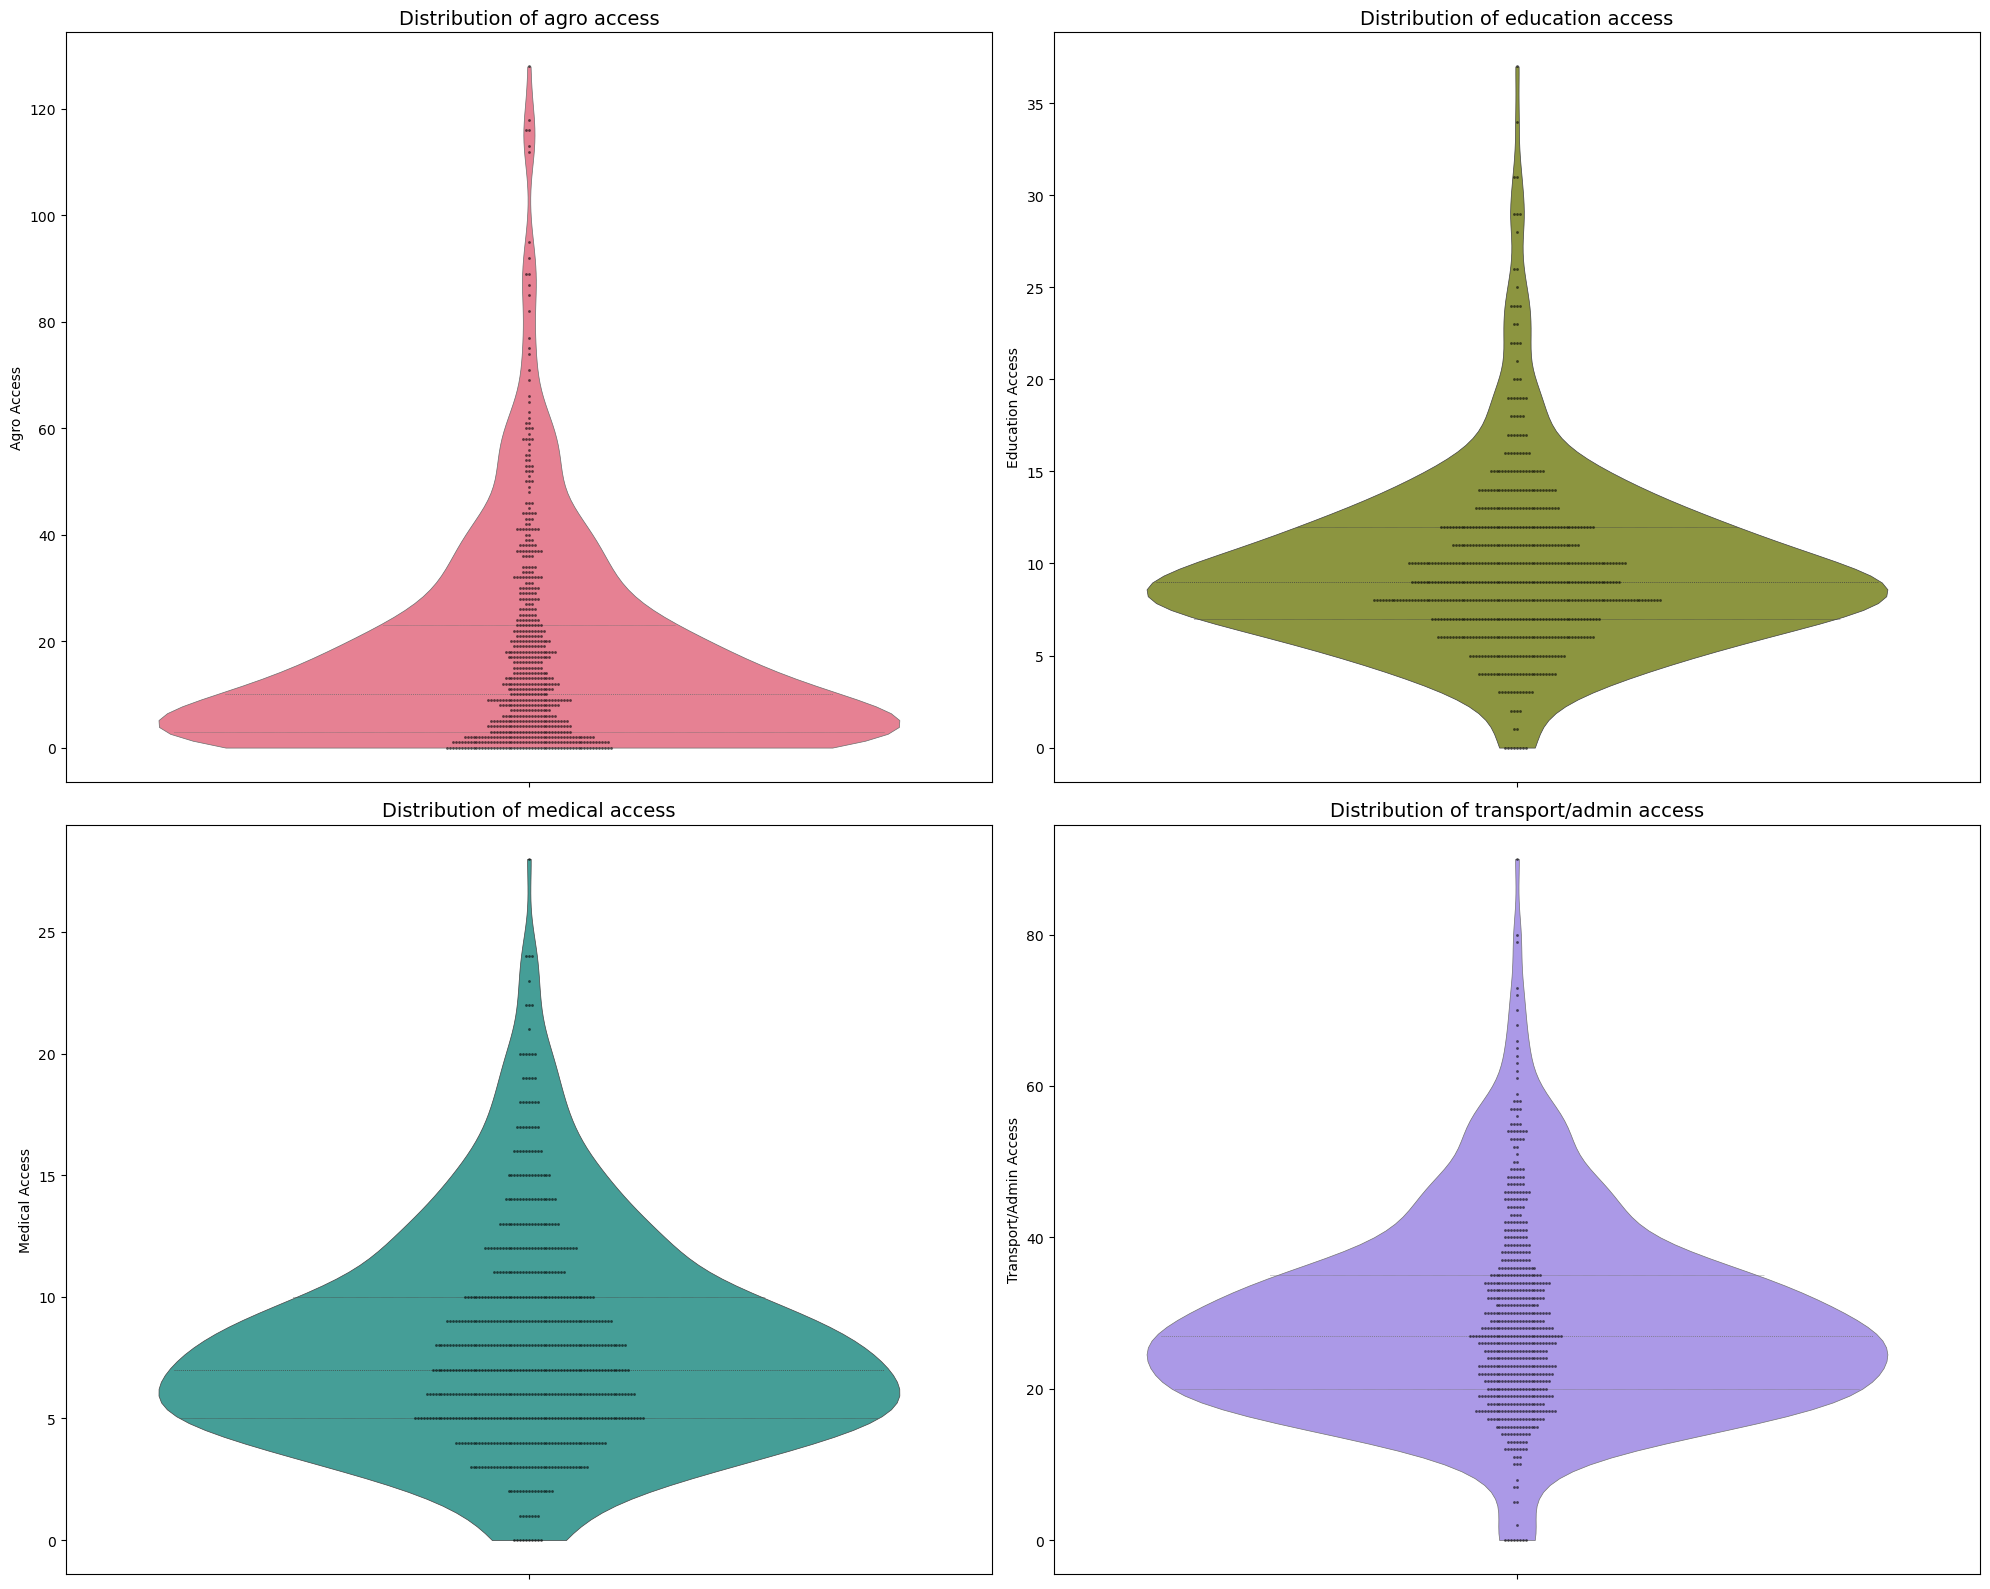

In [16]:
# Ignore warnings
warnings.filterwarnings('ignore')

# List of categories to plot
categories = ['agro_access', 'education_access', 'medical_access', 'transport/admin_access']

# Setup the figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 16), dpi=100)
axes = axes.flatten()  # Flattening the array of axes for easy iteration

# Improved color palette - using a different color for each category
palette = sns.color_palette("husl", len(categories))

for i, category in enumerate(categories):
    ax = axes[i]
    
    # Create violin plot with enhanced visuals
    sns.violinplot(y=boundary_gdf[category], ax=ax, palette=[palette[i]], cut=0, inner='quartile', linewidth=0.5, alpha=0.6)
    
    # Add swarmplot inside violin plot
    sns.swarmplot(y=boundary_gdf[category], ax=ax, color='k', size=2, alpha=0.6)
    
    # Set titles and labels
    ax.set_title(f"Distribution of {category.replace('_', ' ')}", fontsize=14)
    ax.set_ylabel(f"{category.replace('_', ' ').title()}")
    ax.set_xlabel('')

# Optimize the layout
plt.tight_layout()

# Display the plot
plt.show()

The violin plots reveal diverse distribution patterns for different types of access across the state: agro_access is concentrated around a median, indicating uniformity across many blocks; education_access and transport/admin_access show flatter distributions with some regions enjoying higher access, evident from the long tails; and medical_access suggests a uniform trend across the state.

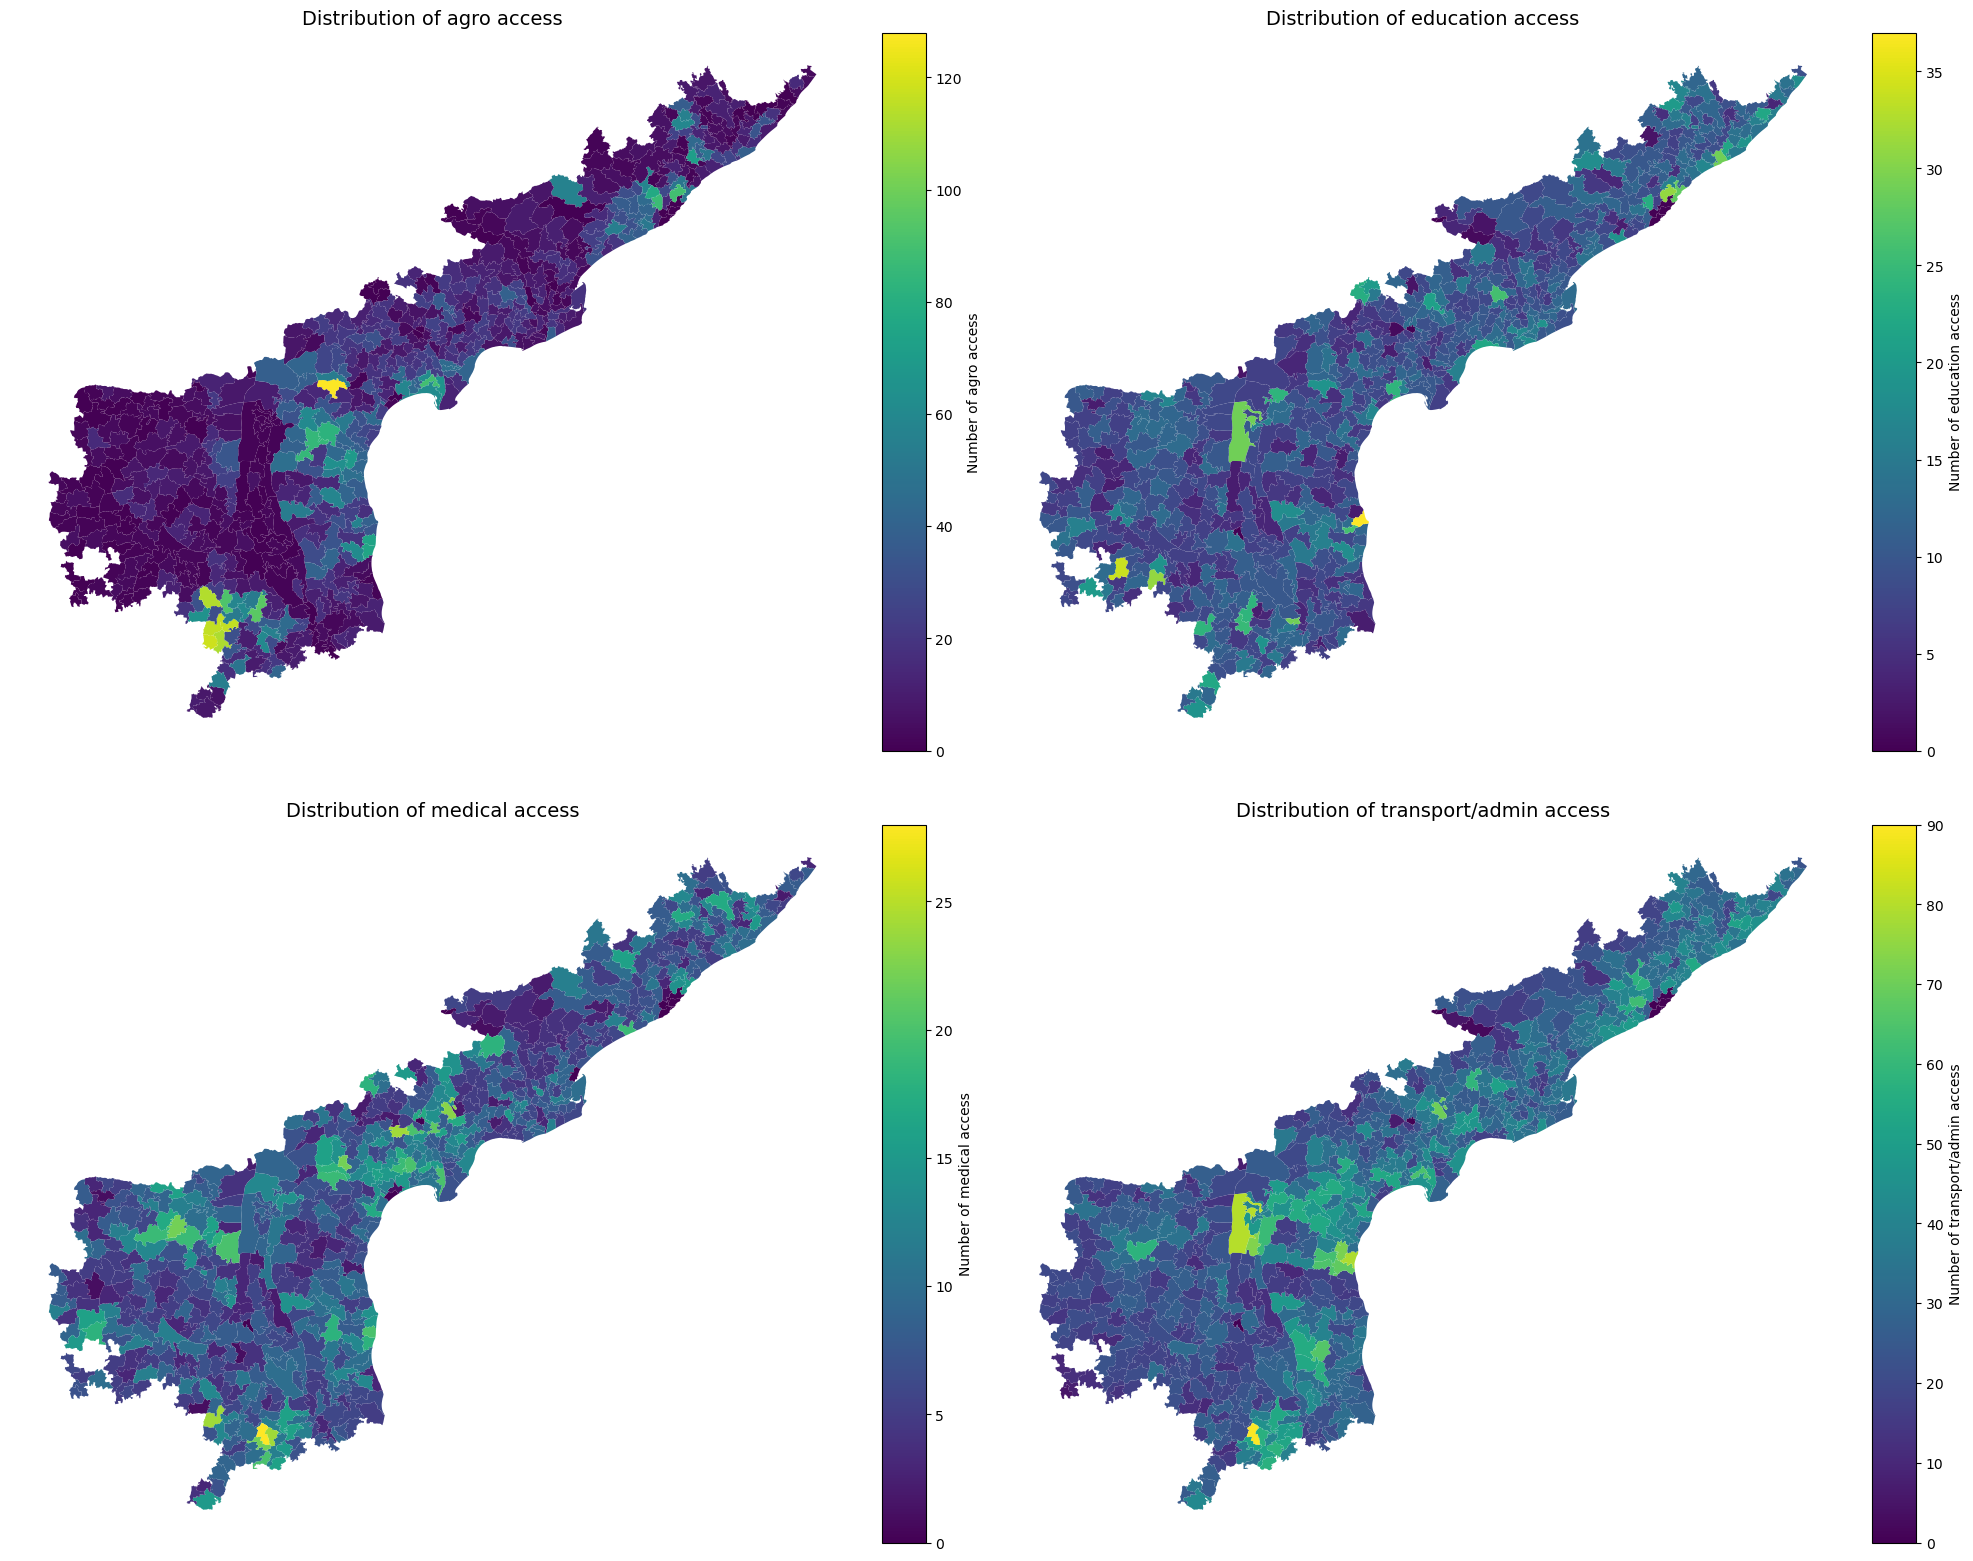

In [17]:
# List of categories to plot
categories = ['agro_access', 'education_access', 'medical_access', 'transport/admin_access']

# Setting up the plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 16), dpi=100)

# Flattening the array of axes for easy iteration
axes = axes.flatten()

# Defining a colormap
colormap = 'viridis'

for i, category in enumerate(categories):
    ax = axes[i]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Plotting
    boundary_gdf.plot(column=category, ax=ax, legend=True, cax=cax, cmap=colormap,
                      legend_kwds={'label': f"Number of {category.replace('_', ' ')}", 'orientation': "vertical"})

    ax.set_title(f"Distribution of {category.replace('_', ' ')}", fontsize=14)
    ax.set_axis_off()

    # Setting up the color bar size and label font size
    cax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

From the plots, it can be observed that the geographical distribution of the facilities is denser towards the Eastern Side which is also the coastal side of Andhra Pradesh.

### 4.2.4 Facility Density per Block

Blocks vary greatly in size and thus can skew perceptions of accessibility if using just a count per block. The best matrix to use for comparison would have been "facility_count_per_population" but as population data blockwise isn't available, so we will "facility_count_per_area" as proxy, thus removing the differences in area effects, improving comparability, & thus acting as a more refined measure to show the spatial dynamics. 
- `agro_access` converted to `agro_density`
- `education_access` converted to `education_density`
- `medical_access` converted to `medical_density`
- `transport/admin_access` converted to `transport_admin_density`

In [18]:
# Step 1: Convert CRS to UTM zone suitable for Andhra Pradesh (EPSG:32644)
boundary_gdf = boundary_gdf.to_crs(epsg=32644)

# Calculate the area of each block in square kilometers
boundary_gdf['area_sq_km'] = boundary_gdf.area / 1e6

# Step 2: Calculate densities i.e. facilities count per sq kms
boundary_gdf['agro_density'] = boundary_gdf['agro_access'] / (boundary_gdf['area_sq_km'] + 1e-9)
boundary_gdf['education_density'] = boundary_gdf['education_access'] / (boundary_gdf['area_sq_km'] + 1e-9)
boundary_gdf['medical_density'] = boundary_gdf['medical_access'] / (boundary_gdf['area_sq_km'] + 1e-9)
boundary_gdf['transport_admin_density'] = boundary_gdf['transport/admin_access'] / (boundary_gdf['area_sq_km'] + 1e-9)
boundary_gdf.head()

,BLOCK_ID,STATE_ID,DISTRICT_I,geometry,agro_access,education_access,medical_access,transport/admin_access,area_sq_km,agro_density,education_density,medical_density,transport_admin_density
0,4662,2,206.0,"POLYGON ((435933.282 1780897.123, 435956.341 1...",22,12,14,36,142.105591,0.154814,0.084444,0.098518,0.253333
1,5163,2,206.0,"POLYGON ((486820.268 1774784.896, 486860.730 1...",66,10,20,53,186.316238,0.354236,0.053672,0.107344,0.284463
2,5189,2,206.0,"MULTIPOLYGON (((377452.055 1799281.042, 377738...",16,6,6,36,229.768117,0.069635,0.026113,0.026113,0.156680
3,5444,2,206.0,"POLYGON ((413393.477 1825734.855, 413331.869 1...",32,14,11,43,238.598729,0.134116,0.058676,0.046103,0.180219
4,6312,2,206.0,"POLYGON ((333102.894 1817377.245, 332971.426 1...",7,8,7,36,520.931851,0.013437,0.015357,0.013437,0.069107


In [19]:
boundary_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   BLOCK_ID                 669 non-null    int64   
 1   STATE_ID                 669 non-null    int64   
 2   DISTRICT_I               663 non-null    float64 
 3   geometry                 669 non-null    geometry
 4   agro_access              669 non-null    int64   
 5   education_access         669 non-null    int64   
 6   medical_access           669 non-null    int64   
 7   transport/admin_access   669 non-null    int64   
 8   area_sq_km               669 non-null    float64 
 9   agro_density             669 non-null    float64 
 10  education_density        669 non-null    float64 
 11  medical_density          669 non-null    float64 
 12  transport_admin_density  669 non-null    float64 
dtypes: float64(6), geometry(1), int64(6)
memory usage: 68.1 K

### 4.2.5 Data Standardization

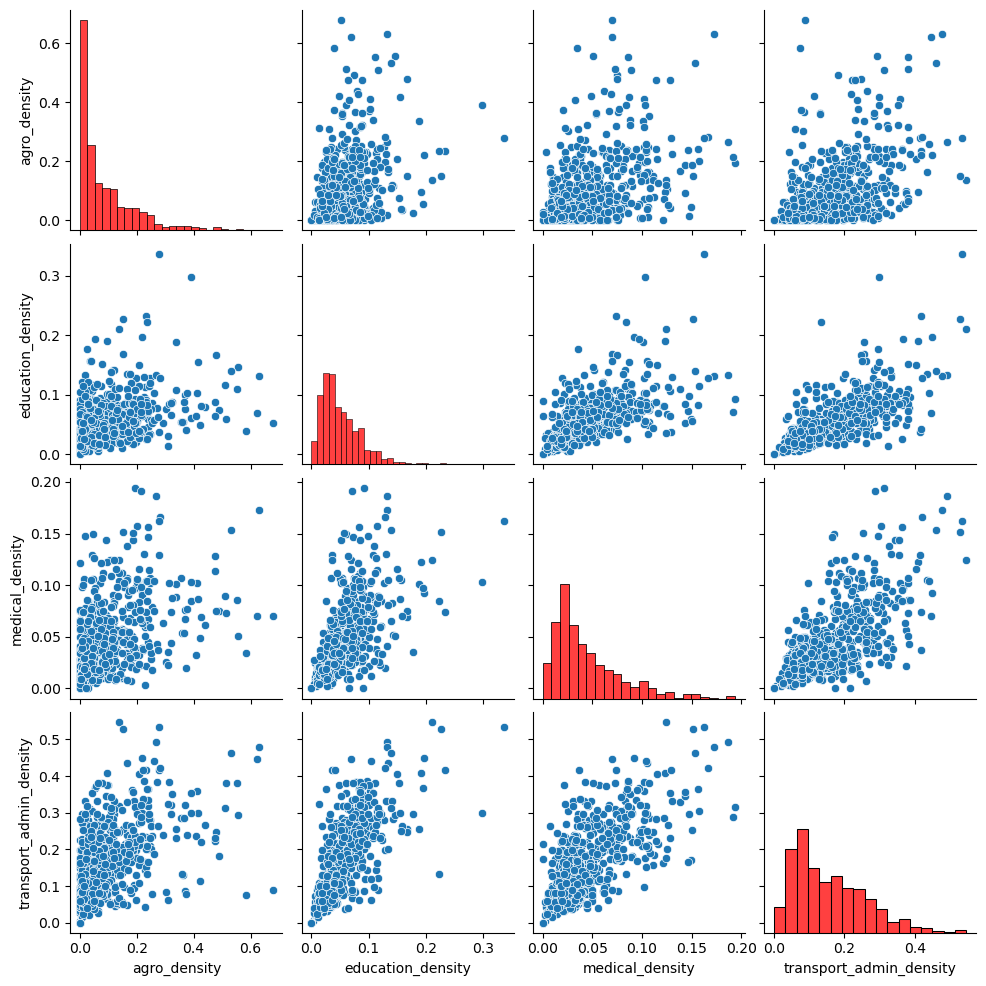

In [20]:
# List of density categories
categories = ['agro_density', 'education_density', 'medical_density', 'transport_admin_density']
sns.pairplot(boundary_gdf[categories], diag_kws={'color':'red'})
# Ignore warnings in output
warnings.filterwarnings('ignore')

Now, let us check the distribution of the categories by Shapiro-Wilk test

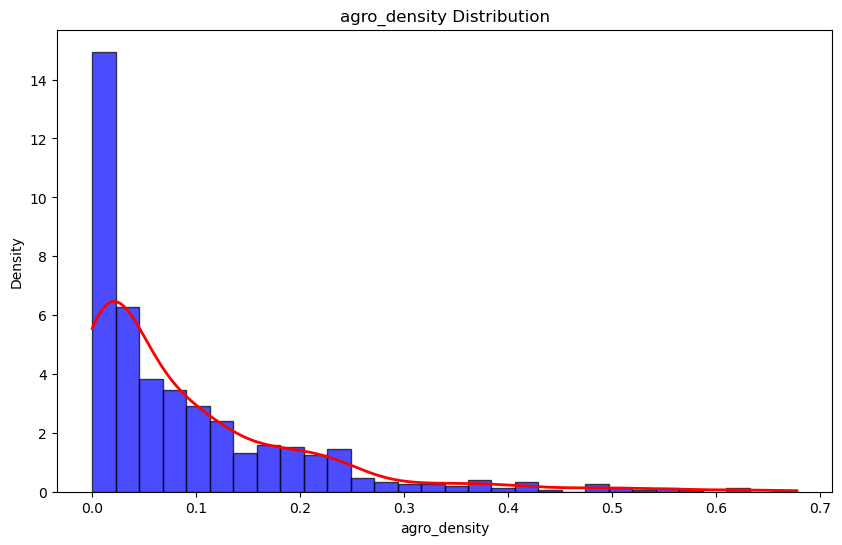

Statistics=0.771, p=0.000 for agro_density
The distribution of agro_density isnt normal.



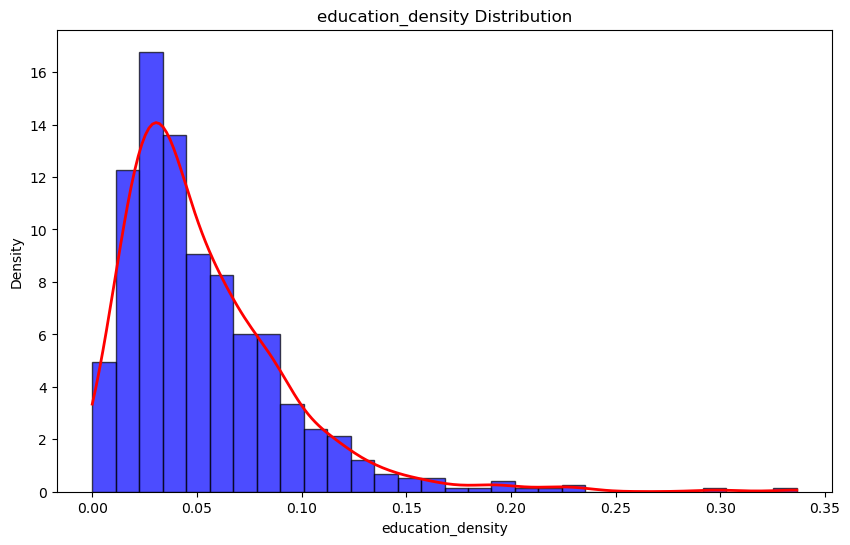

Statistics=0.844, p=0.000 for education_density
The distribution of education_density isnt normal.



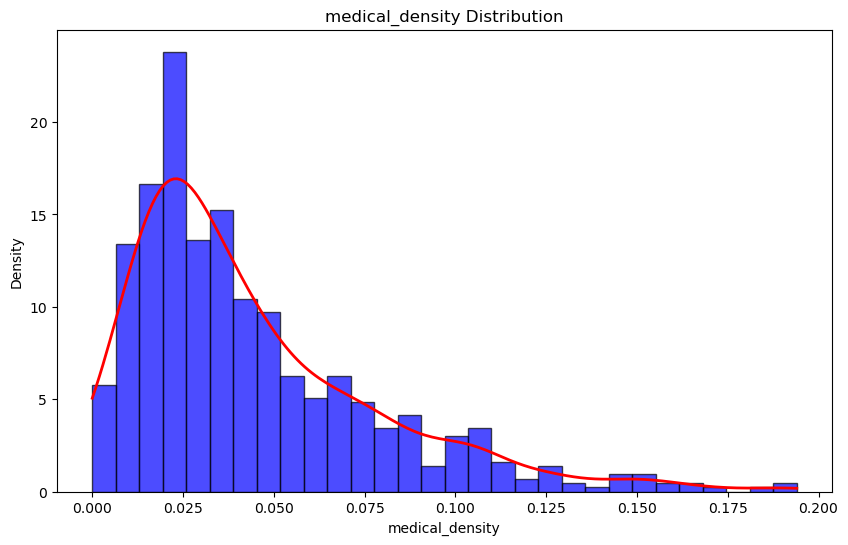

Statistics=0.870, p=0.000 for medical_density
The distribution of medical_density isnt normal.



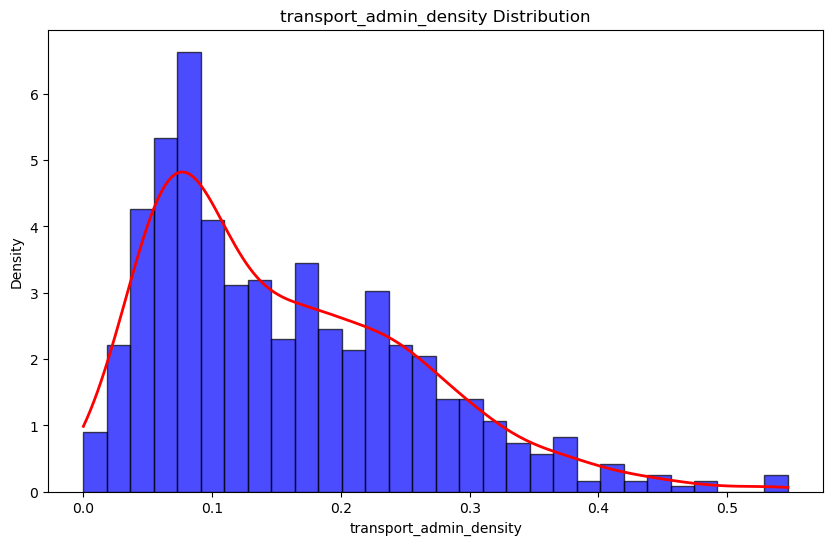

Statistics=0.932, p=0.000 for transport_admin_density
The distribution of transport_admin_density isnt normal.



In [21]:
# List of density categories
categories = ['agro_density', 'education_density', 'medical_density', 'transport_admin_density']

# Plot histograms and perform Shapiro-Wilk test for each category
for category in categories:
    plt.figure(figsize=(10, 6))
    data = boundary_gdf[category]
    density = gaussian_kde(data, bw_method='scott')
    xs = np.linspace(data.min(), data.max(), 200)
    plt.hist(data, bins=30, alpha=0.7, color='blue', edgecolor='black', density=True)
    plt.plot(xs, density(xs), color='red', linewidth=2)  # KDE plot
    plt.title(f'{category} Distribution')
    plt.xlabel(category)
    plt.ylabel('Density')
    plt.show()
    
    # Shapiro-Wilk Test
    stat, p = shapiro(data)
    print(f'Statistics={stat:.3f}, p={p:.3f} for {category}')
    
    # Interpretation
    alpha = 0.05
    if p > alpha:
        print(f'The distribution of {category} appears to be normal.\n')
    else:
        print(f'The distribution of {category} isnt normal.\n')

As distribtion isn't normal so it is better to standardize the data.

In [22]:
# Using Robust Scaler
rs = RobustScaler(quantile_range=(10.0, 90.0))

In [23]:
raw = boundary_gdf[['BLOCK_ID',	'agro_density', 'education_density', 'medical_density',	'transport_admin_density']].set_index('BLOCK_ID').copy()
raw.head()

,agro_density,education_density,medical_density,transport_admin_density
BLOCK_ID,,,,
4662,0.154814,0.084444,0.098518,0.253333
5163,0.354236,0.053672,0.107344,0.284463
5189,0.069635,0.026113,0.026113,0.156680
5444,0.134116,0.058676,0.046103,0.180219
6312,0.013437,0.015357,0.013437,0.069107


In [24]:
normed = raw.copy()
for c in raw.columns.values:
    normed[c] = rs.fit_transform(raw[c].values.reshape(-1,1))
    print("The range of {} is [{}, {}]".format(c, normed[c].min(), normed[c].max()))
normed.head()

The range of agro_density is [-0.21119364932403242, 2.745578438514328]
The range of education_density is [-0.49748151041940236, 3.4633218134812402]
The range of medical_density is [-0.413402741905282, 1.9422924082540414]
The range of transport_admin_density is [-0.5331069338303377, 1.6807409570396432]


,agro_density,education_density,medical_density,transport_admin_density
BLOCK_ID,,,,
4662,0.464083,0.496319,0.782796,0.491947
5163,1.333930,0.134171,0.889962,0.617907
5189,0.092545,-0.190162,-0.096338,0.100862
5444,0.373801,0.193059,0.146369,0.196109
6312,-0.152582,-0.316748,-0.250247,-0.253481


### 4.2.6 Data Mapping Functions

In [25]:
def mapping_clusters(labels_cluster):
    boundary_gdf['cluster_nm'] = labels_cluster
    boundary_gdf.plot(column='cluster_nm', categorical=True, legend=True, figsize=(12,8), cmap='Paired');

In [26]:
# adapted from this tutorial: https://towardsdatascience.com/how-to-make-stunning-radar-charts-with-python-implemented-in-matplotlib-and-plotly-91e21801d8ca
def radar_plot_cluster_centroids(df_cluster_centroid):
    # parameters
    # df_cluster_centroid: a dataframe with rows representing a cluster centroid and columns representing variables
    
    # add an additional element to both categories and restaurants that’s identical to the first item
    # manually 'close' the line
    categories = df_cluster_centroid.columns.values.tolist()
    categories = [*categories, categories[0]]
    
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))
    
    plt.figure(figsize=(12, 8))
    plt.subplot(polar=True)
    for index, row in df_cluster_centroid.iterrows():
        centroid = row.tolist()
        centroid = [*centroid, centroid[0]]
        label = "Cluster {}".format(index)
        plt.plot(label_loc, centroid, label=label)
    plt.title('Cluster centroid comparison', size=20, y=1.05)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
    plt.legend()
    plt.show()

## 5.0 | Methodology
<a id="ID_met"></a>

Building upon the preliminary examination of the distribution of public service facilities conducted in EDA, in this section we use different clustering algorithms to check for clusters and the nature of these clusters concerning different public service facilities.  

### 5.1 K-means Clustering
The K-means clustering algorithm is a simple partitional clustering algorithm. In this, the prediction is based on the number of centroids present (K) and the nearest mean. So, it will help us partition these facilities into groups based on their proximity and similarities.

### 5.2 Hierarchical Clustering
Here we will use Agglomerative Clustering which is a bottom-up approach and it starts with each data point as its own cluster and progressively merging the two most similar clusters; process is repeated until all data points are united into a single cluster. So, in our study it will allow us to visually and analytically discern the hierarchical structure of facility distribution across different blocks.

### 5.3 DBSCAN
DBSCAN excels in analyzing large spatial datasets by evaluating the local density of data points to establish clusters. This method surpasses K-Means, which partitions data into pre-set clusters, by also pinpointing outliers or noise, thus effectively identifying data points that are not part of any cluster.

### 5.4 Comparison of Clustering Performance
We will use the Calinski-Harabasz Index to check the performance of the three clustering algorithms for our study. The Calinski-Harabasz Index checks whether the clusters are dense and well-separated, thus relating to a model with better-defined clusters. So, the higher the value, the better the clustering performance (Calinski-Harabasz criterion clustering evaluation object - MATLAB, 2024) 

## 6.0 | Results
<a id="ID_res"></a>

### 6.1 Using K-means

We first check the Silhouette Score for 'k'

In [27]:
# Assure min_k starts at 2 for silhouette score calculation
min_k = 2
max_k = 10
range_k = range(min_k, max_k + 1)

silhouette_scores = []

for k in range_k:
    km = KMeans(n_clusters=k, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=42)
    km.fit(normed)
    cluster_labels = km.labels_
    # Check to ensure there are at least two clusters
    if len(set(cluster_labels)) > 1:
        silhouette_avg = silhouette_score(normed, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"Silhouette Score for k={k}: {silhouette_avg}")
    else:
        print(f"Skipping k={k} due to a single cluster.")

Silhouette Score for k=2: 0.47341697436360497
Silhouette Score for k=3: 0.3936692258091543
Silhouette Score for k=4: 0.3904989379923257
Silhouette Score for k=5: 0.3175810477352035
Silhouette Score for k=6: 0.34996004468895736
Silhouette Score for k=7: 0.3041968137335369
Silhouette Score for k=8: 0.29909959438280753
Silhouette Score for k=9: 0.21678551060118753
Silhouette Score for k=10: 0.2199361415546873


Now, we will do Elbow Analysis, to check the "elbowpoint" i.e. where rate of decrease in SSE will not significantly change with increase in clusters.

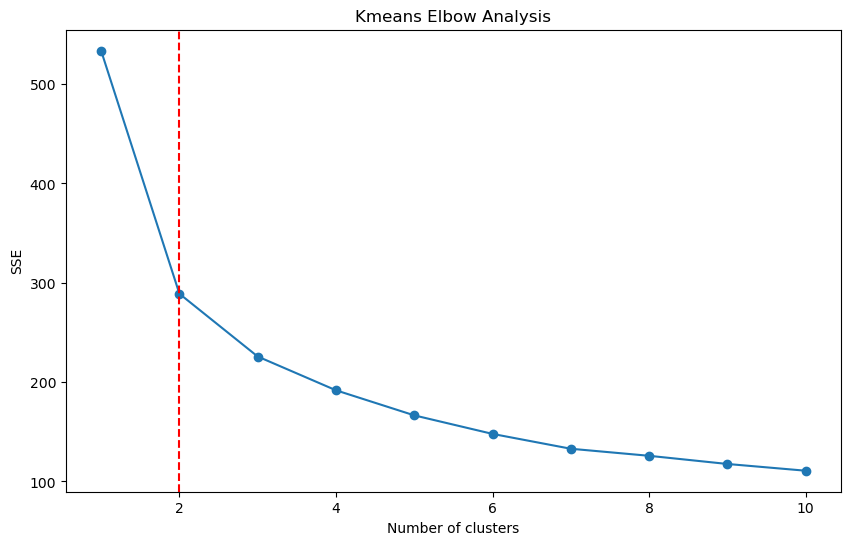

In [28]:
# SSE list to store the sum of squared errors
list_SSE = []

# Range of k values to try
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)

# Calculate SSE for each k
for i in range_k:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=42
    )
    km.fit(normed)
    list_SSE.append(km.inertia_)

# Plotting the SSE values for each k to find the elbow
plt.figure(figsize=(10, 6))
plt.plot(range_k, list_SSE, marker='o')
plt.title('Kmeans Elbow Analysis')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.axvline(x=2, linestyle='--', color='r')
plt.show()

Thus, from both the Silhouette Score & Elbow Method, we can observe that at `k_cluster` = 2, we have the **Elbowpoint** as well as the maximum **Silhouette Score**, that means there at k=2, the data points are more closer to their cluster than any other clusters. Thus, we use the `k_cluster` = 2 for K-means.

In [29]:
k_cluster = 2
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(normed)

KMeans(n_clusters=2, random_state=1)

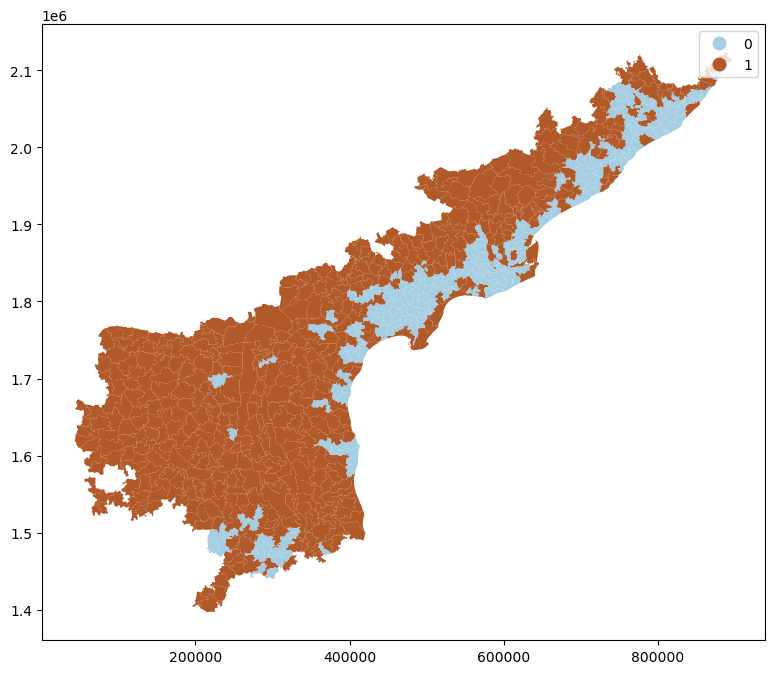

In [30]:
mapping_clusters(kmeans_method.labels_);

In [31]:
pd.Series(kmeans_method.labels_).value_counts()

1    460
0    209
Name: count, dtype: int64

K-Mean Clustering


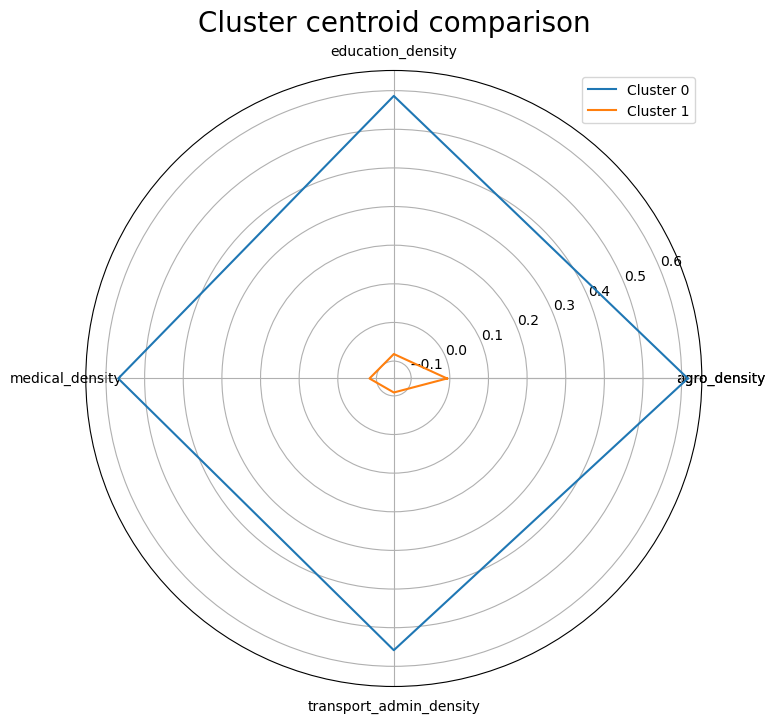

In [32]:
df_cluster_centroid = pd.DataFrame(kmeans_method.cluster_centers_, columns=normed.columns)
print("K-Mean Clustering")
radar_plot_cluster_centroids(df_cluster_centroid)

From K-Means:-
- Cluster-1
  Being **most deprived cluster** with the lowest density values for public service indices (i.e. `education_density`, `agro_density`, `medical_density` & `transport_admin_density`). Also, it can been seen the deprived regions are the inland blocks & comprise 460 blocks out of 669 blocks (~69%) thus showing the disparity of public service facilities in the inland region.
- Cluster-0
  Being the **most privileged cluster** with the highest density values for public service indices. It can be seen from the map that the privileged region is on the coastal side & comprises 209 blocks out of 669 (~31%) total blocks.

### 6.2 Using Hierarchical Clustering

In [33]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, leaf_rotation=90., **kwargs)

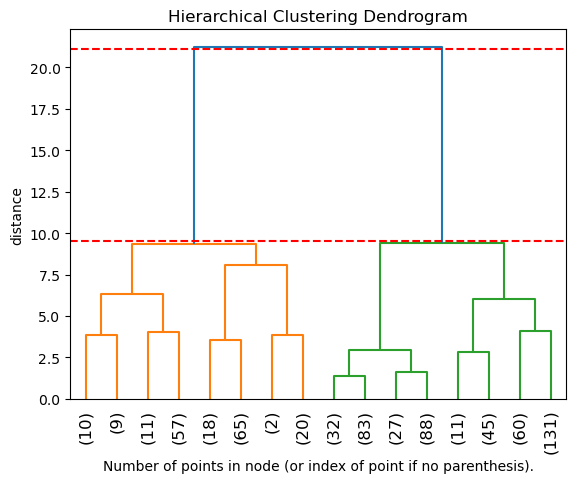

In [34]:
agg_cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(normed)
ax = plt.gca()
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agg_cluster, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel('distance')
# the two red lines are drawn manually, as we see that the gap between the two lines is larger than any other gap in the tree
plt.hlines(9.5, ax.get_xlim()[0], ax.get_xlim()[1], linestyle='dashed', color='r')
plt.hlines(21.1, ax.get_xlim()[0], ax.get_xlim()[1], linestyle='dashed', color='r')
plt.show()

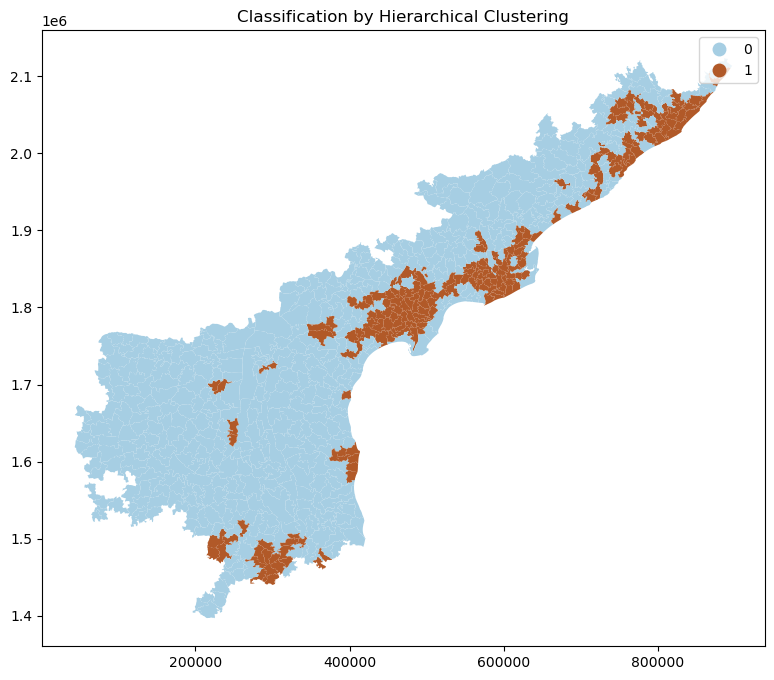

In [35]:
agg_cluster = AgglomerativeClustering(distance_threshold=None, n_clusters=2).fit(normed)
mapping_clusters(agg_cluster.labels_)
plt.title('Classification by Hierarchical Clustering')
plt.show()

In [36]:
pd.Series(agg_cluster.labels_).value_counts()

0    477
1    192
Name: count, dtype: int64

Agglomerative Clustering


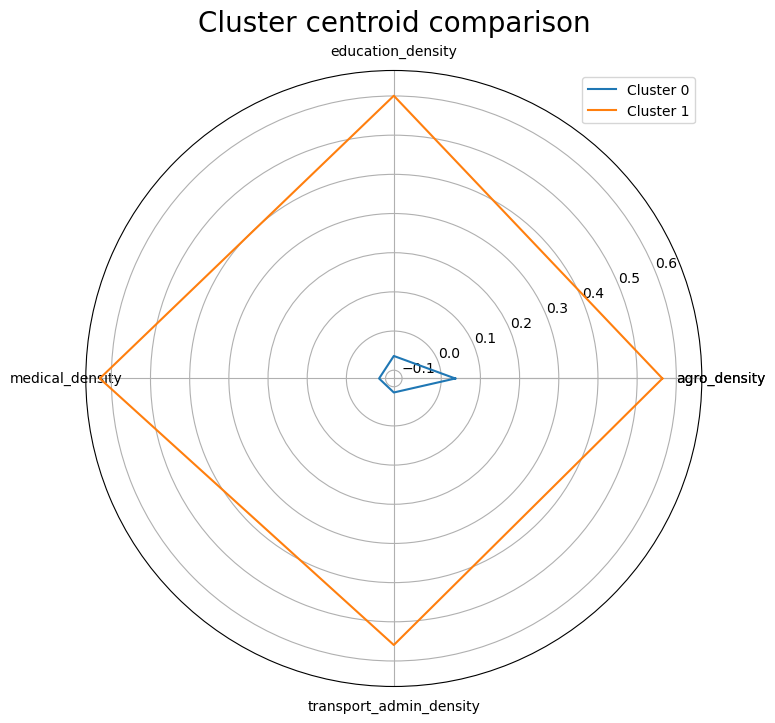

In [37]:
# Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=2, compute_full_tree=True)
agg_labels = agg_clustering.fit_predict(normed)
agg_data = normed.copy()
agg_data['cluster'] = agg_labels
agg_centroids = agg_data.groupby('cluster').mean()

# Visualize the centroids
print("Agglomerative Clustering")
radar_plot_cluster_centroids(agg_centroids)

Similar to k-means, there is also huge difference between the two clusters produced by hierarchical clustering
- Cluster-0
  Being **most deprived cluster** with the lowest density values for public service indices . Also, it can been seen the deprived regions are the inland blocks & comprise 477 blocks out of 669 blocks (~72%) thus showing the disparity of public service facilities in the inland region.
- Cluster-1
  Being the **most privileged cluster** with the highest density values for public service indices. It can be seen from the map that the privileged region is on the coastal side & comprises 192 blocks out of 669 (~28%) total blocks.

### 6.3 Using DBSCAN

We use the k-Distance Plot to check the best value of epsilon

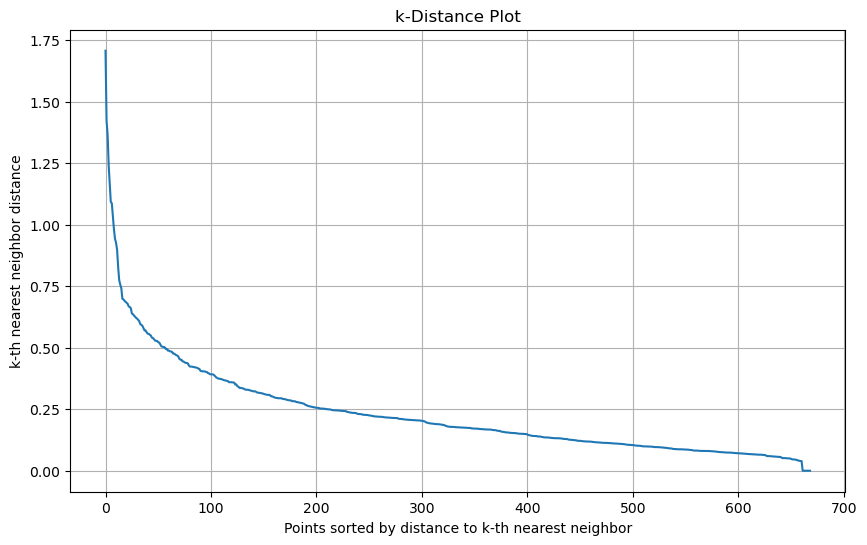

In [38]:
# Set k to minPts - 1, where minPts is typically chosen as some function of the number of dimensions in our data
minPts = normed.shape[1] + 1 # dimensions of our dataset + 1 
k = minPts - 1

# Compute the nearest neighbors using NearestNeighbors from sklearn
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(normed)
distances, indices = nbrs.kneighbors(normed)

# Sort the distances
sorted_distances = np.sort(distances[:, k], axis=0)[::-1]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.title('k-Distance Plot')
plt.xlabel('Points sorted by distance to k-th nearest neighbor')
plt.ylabel('k-th nearest neighbor distance')

plt.grid(True)
plt.show()

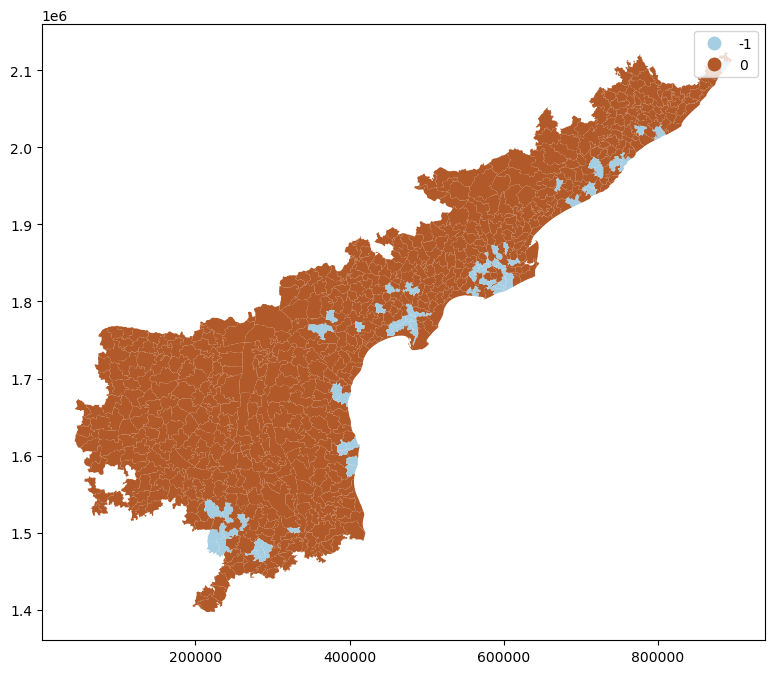

In [39]:
minPts = normed.shape[1] + 1 # we set minPts as normed.shape[1] + 1 which is equal to 5 here.
epsilon = 0.4 # from the K-Distance Plot Above
dbsc = DBSCAN(eps=epsilon, min_samples=minPts)
dbsc.fit(normed)

# We now have our DBSCAN object created, and we can extract the groups it has identified. We do this using the `.labels_` method.
cluster_nm = dbsc.labels_

mapping_clusters(cluster_nm)

In [40]:
pd.Series(dbsc.labels_).value_counts()

 0    605
-1     64
Name: count, dtype: int64

DBSCAN Clustering


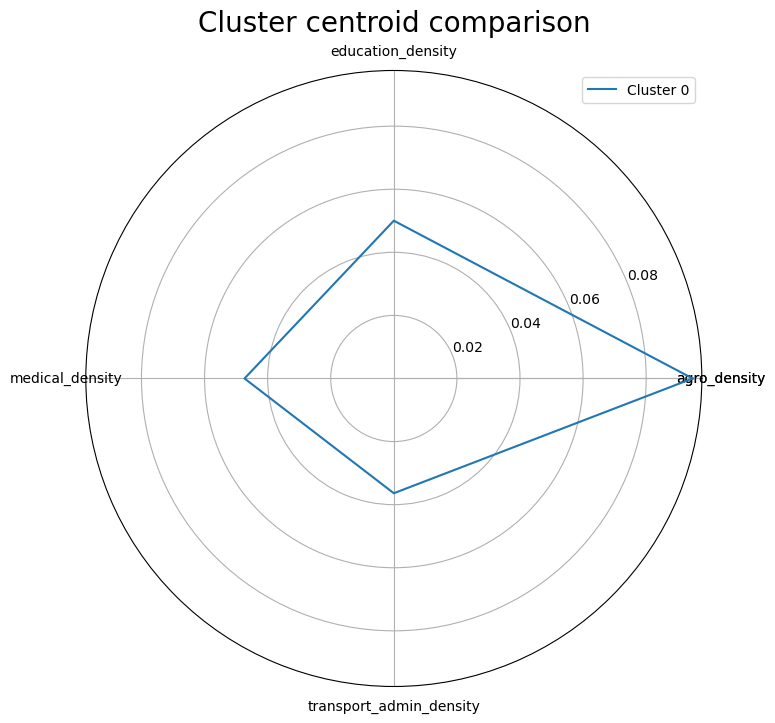

In [41]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=0.4, min_samples=5)  # we set minPts as normed.shape[1] + 1 which is equal to 5 here.
dbscan_labels = dbscan.fit_predict(normed)

# Prepare a DataFrame with the DBSCAN labels
dbscan_data = normed.copy()
dbscan_data['cluster'] = dbscan_labels

# Filter out noise points (-1 labels)
dbscan_clusters = dbscan_data[dbscan_data['cluster'] != -1]

# Calculate centroids of each cluster if there are any clusters
if not dbscan_clusters.empty:
    dbscan_centroids = dbscan_clusters.groupby('cluster').mean()
else:
    print("No clusters found or all points are noise.")

# Visualize the centroids using radar chart if centroids exist
if 'dbscan_centroids' in locals() and not dbscan_centroids.empty:
    print("DBSCAN Clustering")
    radar_plot_cluster_centroids(dbscan_centroids)
else:
    print("No valid clusters to display on radar plot.")

This map differs significantly different from the K-Means & Hierarchical Clustering, as there is only one cluster- Cluster-0 Being **most dense cluster** comprising of 605 blocks out of 669 blocks (~90%) which are the Inland Blocks of the state of Andhra Pradesh.
While the DBSCAN, treats the Coastal blocks which are more privileged in terms of public service indices as obtained from both K-Means and Hierarchical Clustering as **Noise**.

### 6.4 Comparison K-Means, Hierarchical & DBSCAN

In [42]:
# Using the Calinski-Harabasz Index for comparing the clustering performance:
labels_kmeans = kmeans_method.labels_
labels_hierarchical = agg_cluster.labels_
labels_dbscan = dbsc.labels_

# Calinski-Harabasz Index
calinski_harabasz_kmeans = calinski_harabasz_score(normed, labels_kmeans)
calinski_harabasz_hierarchical = calinski_harabasz_score(normed, labels_hierarchical)
calinski_harabasz_dbscan = calinski_harabasz_score(normed, labels_dbscan)

print("Clustering Performance Metrics:")
print(f"K-means: Calinski-Harabasz Index: {calinski_harabasz_kmeans:.2f}")
print(f"Hierarchical: Calinski-Harabasz Index: {calinski_harabasz_hierarchical:.2f}")
print(f"DBSCAN: Calinski-Harabasz Index: {calinski_harabasz_dbscan:.2f}")

Clustering Performance Metrics:
K-means: Calinski-Harabasz Index: 564.68
Hierarchical: Calinski-Harabasz Index: 486.65
DBSCAN: Calinski-Harabasz Index: 264.94


K-means has the highest Calinski-Harabasz Index, indicating that its clusters are denser and more well-separated compared to the other two methods. Hierarchical clustering ranks second, and DBSCAN is significantly lower, suggesting its clusters might be less compact or distinct.

In [43]:
# Create a copy of the normed DataFrame
normed_with_clusters = normed.copy()
# Add cluster labels to the copied DataFrame
normed_with_clusters['labels_kmeans'] = labels_kmeans
normed_with_clusters['labels_hierarchical'] = labels_hierarchical
normed_with_clusters['labels_dbscan'] = labels_dbscan

In [44]:
normed_with_clusters.head()

,agro_density,education_density,medical_density,transport_admin_density,labels_kmeans,labels_hierarchical,labels_dbscan
BLOCK_ID,,,,,,,
4662,0.464083,0.496319,0.782796,0.491947,0,1,0
5163,1.333930,0.134171,0.889962,0.617907,0,1,-1
5189,0.092545,-0.190162,-0.096338,0.100862,1,0,0
5444,0.373801,0.193059,0.146369,0.196109,1,0,0
6312,-0.152582,-0.316748,-0.250247,-0.253481,1,0,0


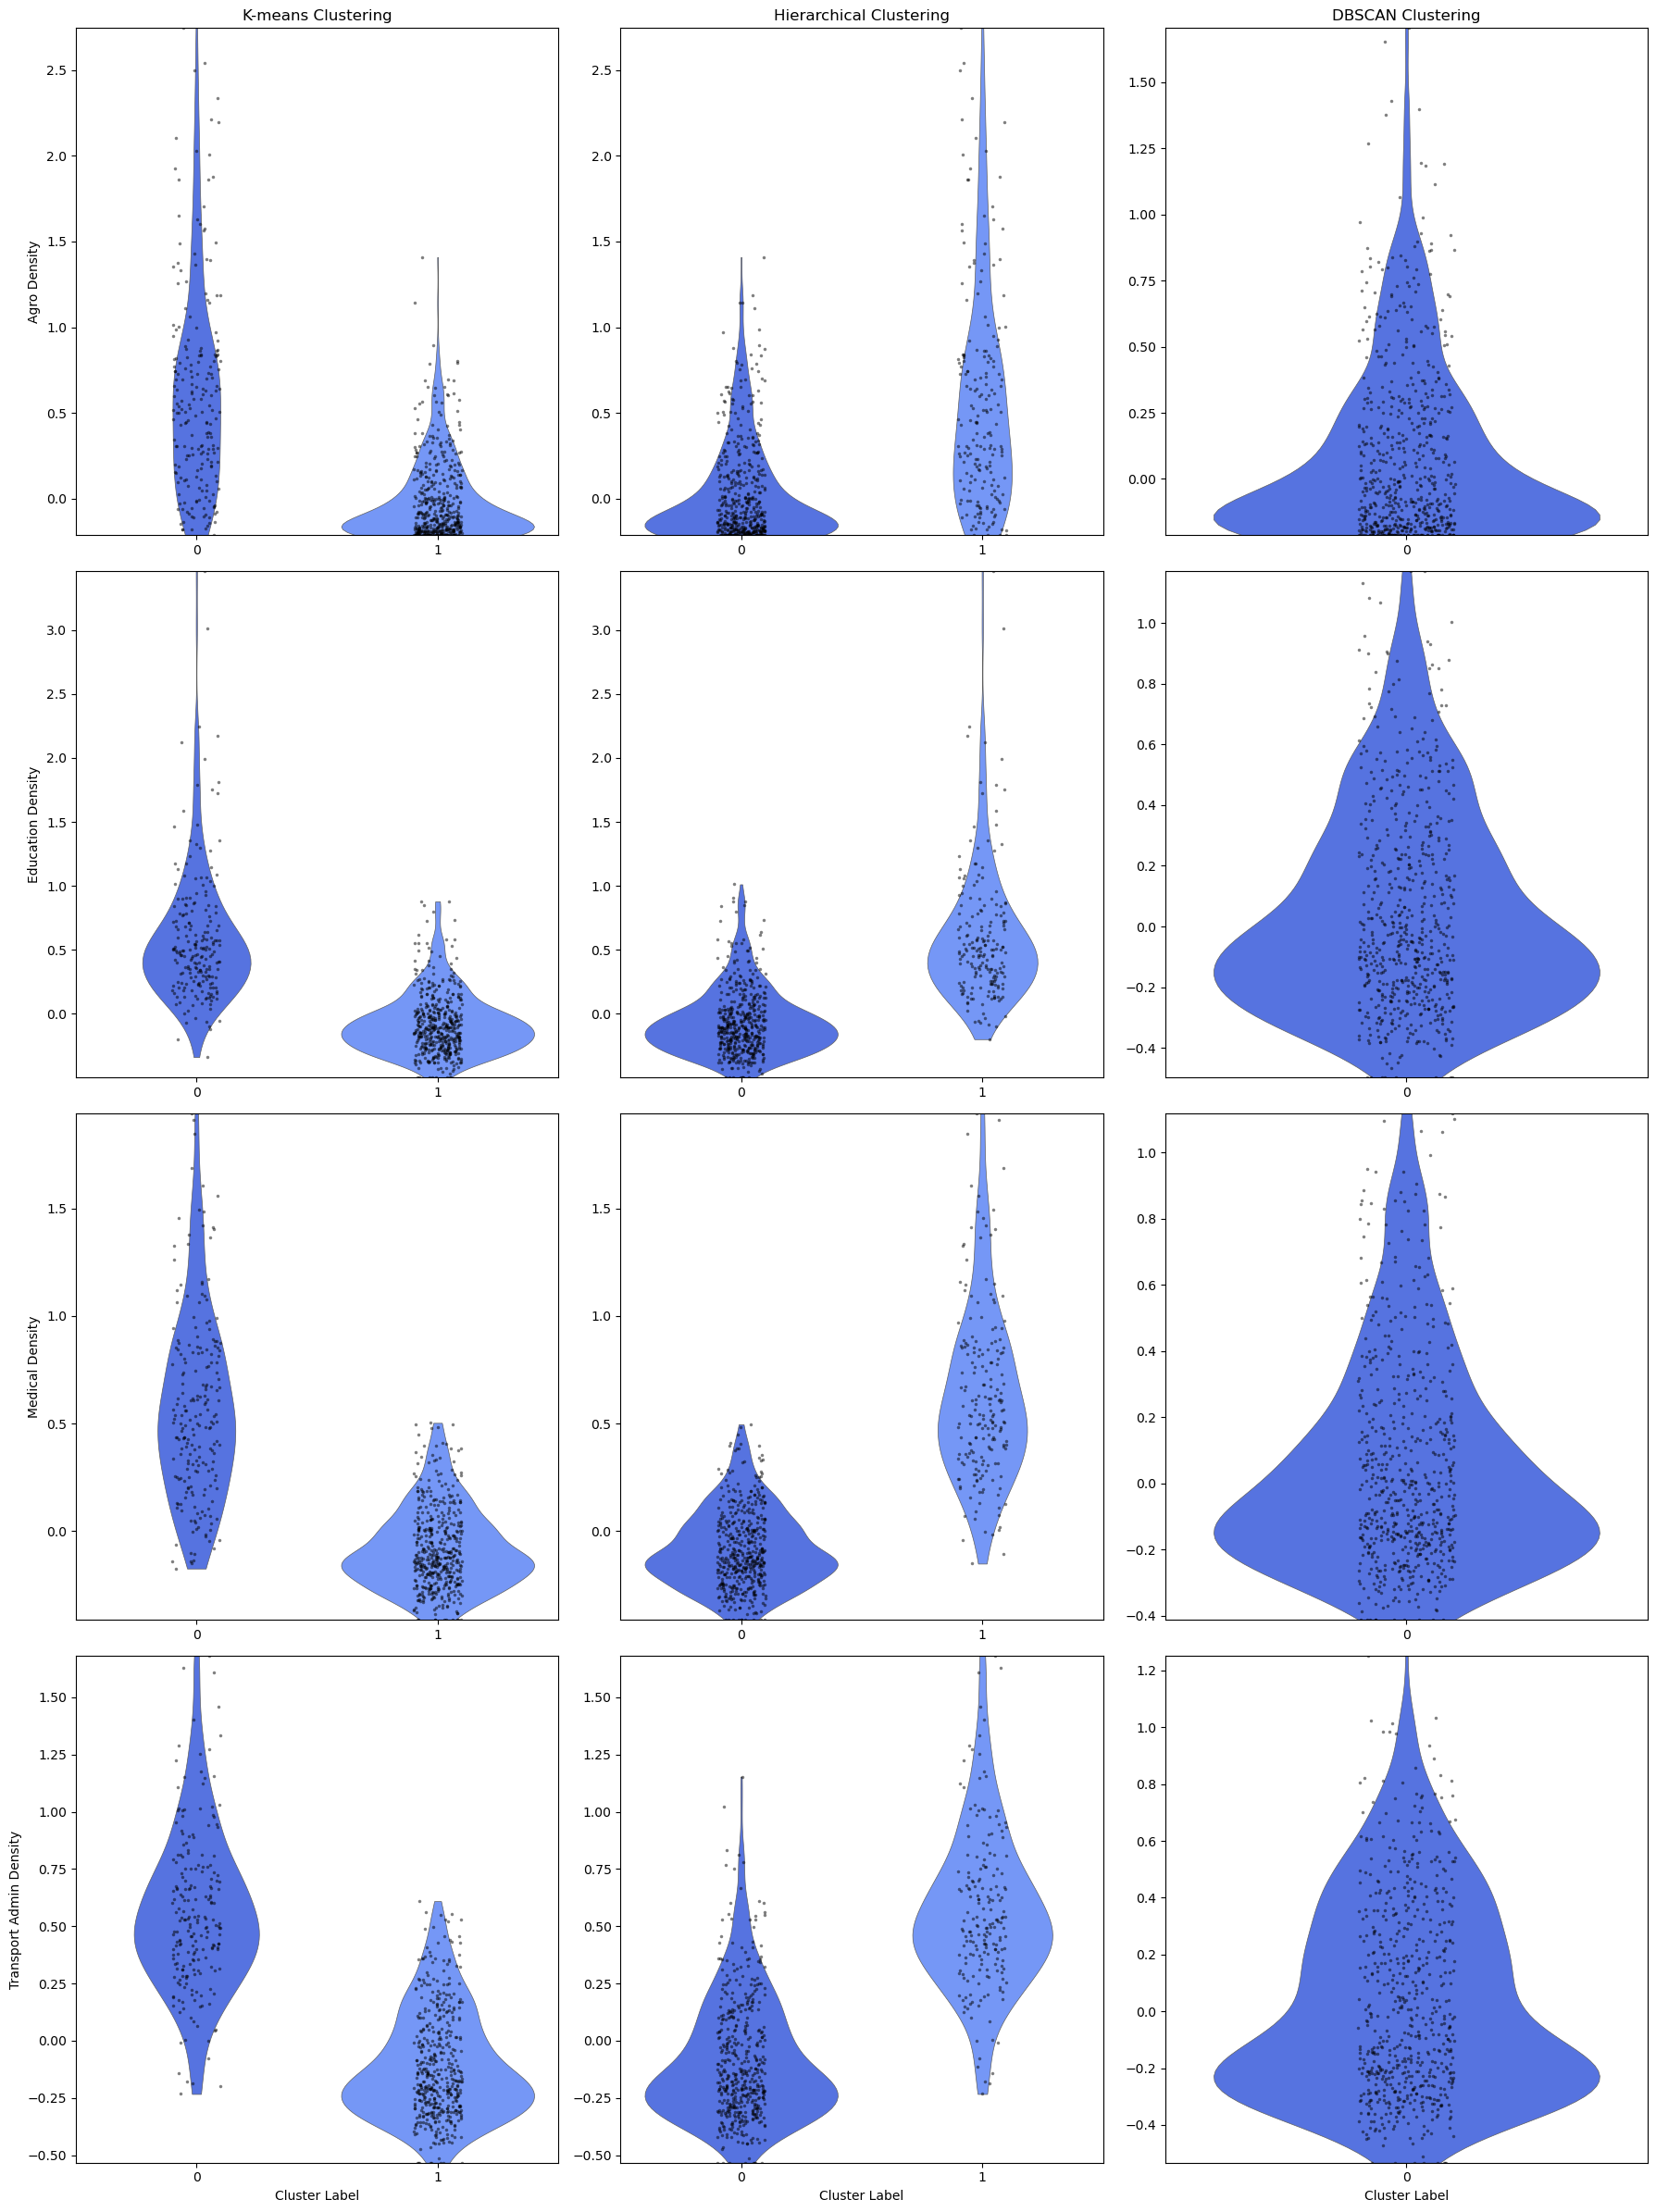

In [45]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Define features and cluster labels before setting up the figure
features = ['agro_density', 'education_density', 'medical_density', 'transport_admin_density']
cluster_labels = ['labels_kmeans', 'labels_hierarchical', 'labels_dbscan']
titles = ['K-means Clustering', 'Hierarchical Clustering', 'DBSCAN Clustering']

# Define a better color palette
palette = sns.color_palette("coolwarm", n_colors=10)  # More distinct colors

# Setup the figure
fig, axes = plt.subplots(len(features), len(cluster_labels), figsize=(18, 6 * len(features)))

# Plotting settings
for i, feature in enumerate(features):
    for j, label in enumerate(cluster_labels):
        ax = axes[i][j]
        if label == 'labels_dbscan':
            # Exclude noise points
            data_to_plot = normed_with_clusters[normed_with_clusters[label] != -1]
        else:
            data_to_plot = normed_with_clusters

        # Violin plot with enhanced visuals
        sns.violinplot(x=data_to_plot[label], y=data_to_plot[feature], ax=ax, cut=0, inner=None, linewidth=0.5,
                       palette=palette, saturation=1, alpha=0.8)
        
        # Add scatter plot for individual observations
        sns.stripplot(x=data_to_plot[label], y=data_to_plot[feature], ax=ax, color='k', size=2.5, jitter=True, alpha=0.5)
        
        # Set common limits for better comparison
        ax.set_ylim(data_to_plot[feature].min(), data_to_plot[feature].max())

        # Set titles and labels
        if i == 0:
            ax.set_title(titles[j])
        if j == 0:
            ax.set_ylabel(f"{feature.replace('_', ' ').title()}")
        else:
            ax.set_ylabel('')

        ax.set_xlabel('Cluster Label' if i == len(features) - 1 else '')

plt.tight_layout()
plt.show()

# Save the figure to a file
#fig.savefig('cluster_analysis_violin_plots.png', dpi=300) 

- The violins for K-means are relatively symmetrical and slender, especially for clusters labeled '0', indicating tight and possibly normally distributed clusters.There is also a distinct separation between the clusters '0' and '1', with little overlap.
- The violins for Hierarchical clustering show a bit more spread and thickness compared to K-means, indicating more variation within the clusters.
Some overlap between clusters is visible, especially in the agro_density feature.
- For DBSCAN, there is a single prominent cluster for most features. Also, the violins are quite broad, suggesting a wider range of data points within the cluster. This could be due to the algorithm's sensitivity to density, causing it to form one large cluster.

## 7.0 | Discussion and Conclusion
<a id="ID_dis"></a>

**RQ1**: **Spatial Distribution:** The analysis identified a notable skew in the distribution of key services—agriculture, education, health, and transportation—primarily toward the eastern coastal belt of Andhra Pradesh. Specifically, agricultural facilities were found to be abundant in the southern and southeastern regions, while educational resources concentrated more in the northern and northeastern areas. Medical facilities showed a central-eastern regional preference, closely followed by transportation services. This eastward distribution trend, aligning with the coastal geography, points toward an imbalance, where the inland western blocks lag, thus signaling a need for strategic developmental initiatives to bridge the service accessibility gap, thereby leading the overall development of this newly bifurcated state of India.

**RQ2**: **Clustering Outcomes:** K-Means & Hierarchical Clustering identifies 2 main clusters, while DBSCAN, identified only a single cluster. Also, in 6.4 it was observed that K-means has the highest clustering performance for this study, indicating that its clusters are denser and more well-separated compared to the other two methods. DBSCAN's sensitivity to the epsilon parameter can sometimes lead to all points falling into a single cluster overshadowing smaller, distinct clusters. So,  K-means and hierarchical clustering might be the more robust for the current clustering scenario which was also confirmed by the high Calinski-Harabasz Index scores in our study.

**RQ3**: **Service Density within Clusters:** The coastal region of Andhra Pradesh emerges as a hub of public services, exhibiting higher `education_density`, `agro_density`, `medical_density` & `transport_admin_density`. This disparity is graphically depicted in the radar plots, contrasting with the inland, which presents as underrepresented in service distribution. 
The broader distribution of `education_density` & `agro_density` across all clusters suggests that these services might be more heterogeneously spread, while the more narrowly confined violins of `medical_density` & `transport_admin_density` hint at a less varied range within these clusters.

The key takeaway from all these findings is that there is a pronounced clustering of services along the coast of Andhra Pradesh. Tackling the disparity between the inland regions and the coastal areas will be crucial for the state's equitable development.

## Reference
<a id="ID_ref"></a>

‘Andhra Pradesh Reorganisation Act, 2014’. (2024). Wikipedia. Available at: https://en.wikipedia.org/w/index.php?title=Andhra_Pradesh_Reorganisation_Act,_2014&oldid=1215794679 

Khan, S. (2015). ‘Distribution of Health and Education Services in the Rural Areas: A Case Study of Aligarh District’.

Khosravi Kazazi, A., Amiri, F., Rahmani, Y., Samouei, R. and Rabiei-Dastjerdi, H. (2022). ‘A New Hybrid Model for Mapping Spatial Accessibility to Healthcare Services Using Machine Learning Methods’. Sustainability. Multidisciplinary Digital Publishing Institute, 14 (21), p. 14106. doi: 10.3390/su142114106.

Cesario, E., Vinci, A. and Zhu, X. (2020). ‘Hierarchical Clustering of Spatial Urban Data’. in Sergeyev, Y. D. and Kvasov, D. E. (eds) Numerical Computations: Theory and Algorithms. Cham: Springer International Publishing, pp. 223–231. doi: 10.1007/978-3-030-39081-5_20

Li Xinyan and Li Deren. (2005). DBSCAN spatial clustering algorithm and its application in urban planning.

PMGSY National GIS - Open Data PMGSY GeoSadak. (no date). Available at: https://geosadak-pmgsy.nic.in/OpenData

Calinski-Harabasz criterion clustering evaluation object - MATLAB. (2024). Available at: https://www.mathworks.com/help/stats/clustering.evaluation.calinskiharabaszevaluation.html

## Appendix
<a id="ID_app"></a>

The concepts and code is largely based on the teaching materials from CASA0006 (Data Science for Spatial Systems) taught by [Dr Huanfa Chen](https://www.ucl.ac.uk/bartlett/casa/people/huanfa-chen).
Access that repository [here](https://github.com/huanfachen/DSSS/tree/main)